<a href="https://www.kaggle.com/code/averma111/houseprice-xgboost-lbgm-and-randomforest?scriptVersionId=125608486" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [163]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [164]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

## Creating datasets with Pandas

In [165]:
ROOT_PATH ='/kaggle/input/house-prices-advanced-regression-techniques'
train = pd.read_csv(ROOT_PATH+'/train.csv')
test = pd.read_csv(ROOT_PATH+'/test.csv')
sample = pd.read_csv(ROOT_PATH +'/sample_submission.csv')


## Creating a summary function 

In [166]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ


In [167]:
summary('train',train)

train shape: (1460, 81)


,dtypes,null,unique,min,median,max,mean,std
Id,int64,0,1460,1,730.5,1460,730.500000,421.610009
MSSubClass,int64,0,15,20,50.0,190,56.897260,42.300571
MSZoning,object,0,5,C (all),NaN,RM,NaN,NaN
LotFrontage,float64,259,110,21.0,69.0,313.0,70.049958,24.284752
LotArea,int64,0,1073,1300,9478.5,215245,10516.828082,9981.264932
...,...,...,...,...,...,...,...,...
MoSold,int64,0,12,1,6.0,12,6.321918,2.703626
YrSold,int64,0,5,2006,2008.0,2010,2007.815753,1.328095
SaleType,object,0,9,COD,NaN,WD,NaN,NaN
SaleCondition,object,0,6,Abnorml,NaN,Partial,NaN,NaN


## Filling the NA values with mean of the column

In [168]:
train['LotFrontage'].fillna((train['LotFrontage'].mean()), inplace=True)

In [169]:
summary('test',test)

test shape: (1459, 80)


,dtypes,null,unique,min,median,max,mean,std
Id,int64,0,1459,1461,2190.0,2919,2190.000000,421.321334
MSSubClass,int64,0,16,20,50.0,190,57.378341,42.746880
MSZoning,object,4,5,NaN,NaN,NaN,NaN,NaN
LotFrontage,float64,227,115,21.0,67.0,200.0,68.580357,22.376841
LotArea,int64,0,1106,1470,9399.0,56600,9819.161069,4955.517327
...,...,...,...,...,...,...,...,...
MiscVal,int64,0,26,0,0.0,17000,58.167923,630.806978
MoSold,int64,0,12,1,6.0,12,6.104181,2.722432
YrSold,int64,0,5,2006,2008.0,2010,2007.769705,1.301740
SaleType,object,1,9,NaN,NaN,NaN,NaN,NaN


## Checking the distribution of the Saleprice in train dataset

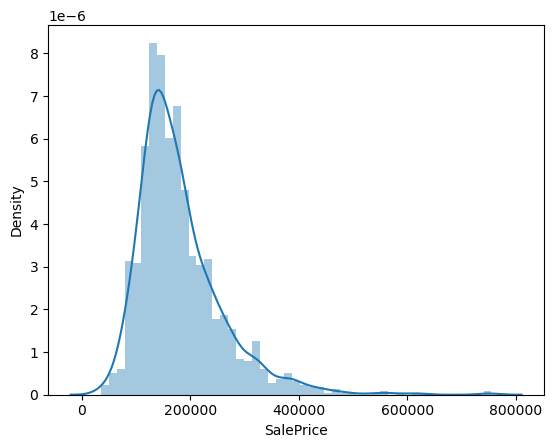

In [170]:
sns.distplot(train['SalePrice'])
plt.show()

## Validating the Saleprice wrt GrLivArea,TotalBsmtSF and YearBuilt

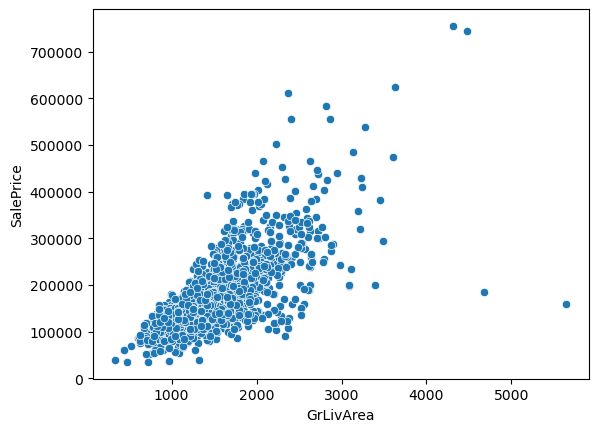

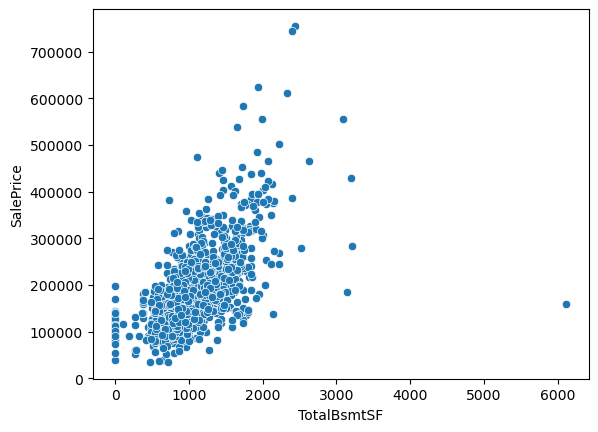

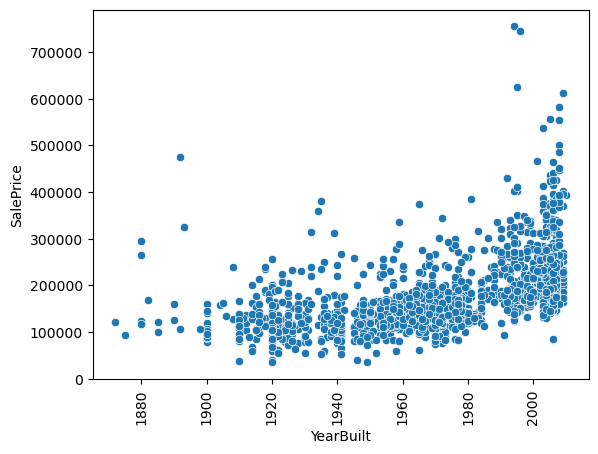

In [171]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)
plt.show()

sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train)
plt.show()

sns.scatterplot(x='YearBuilt', y='SalePrice', data=train)
plt.xticks(rotation=90)
plt.show()

## SalePrice Vs OverallQual, GrLivArea and  GarageCars

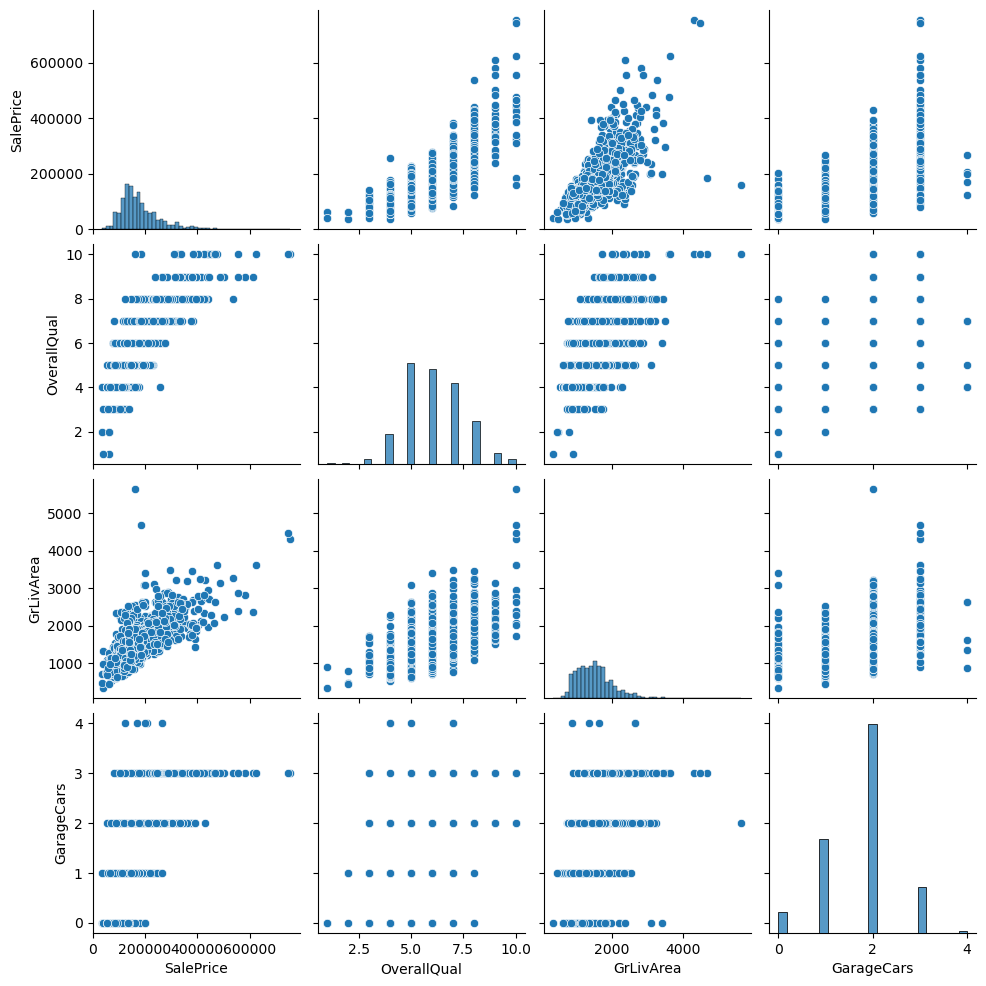

In [172]:
sns.pairplot(train, vars=["SalePrice", "OverallQual", "GrLivArea", "GarageCars"])
plt.show()

In [173]:
test['LotFrontage'].fillna((test['LotFrontage'].mean()), inplace=True)

In [174]:
pd.set_option('display.max_columns', None)
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [175]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train_nums = train.select_dtypes(include=numerics)

## Distribution of all the numerical columns in train dataset

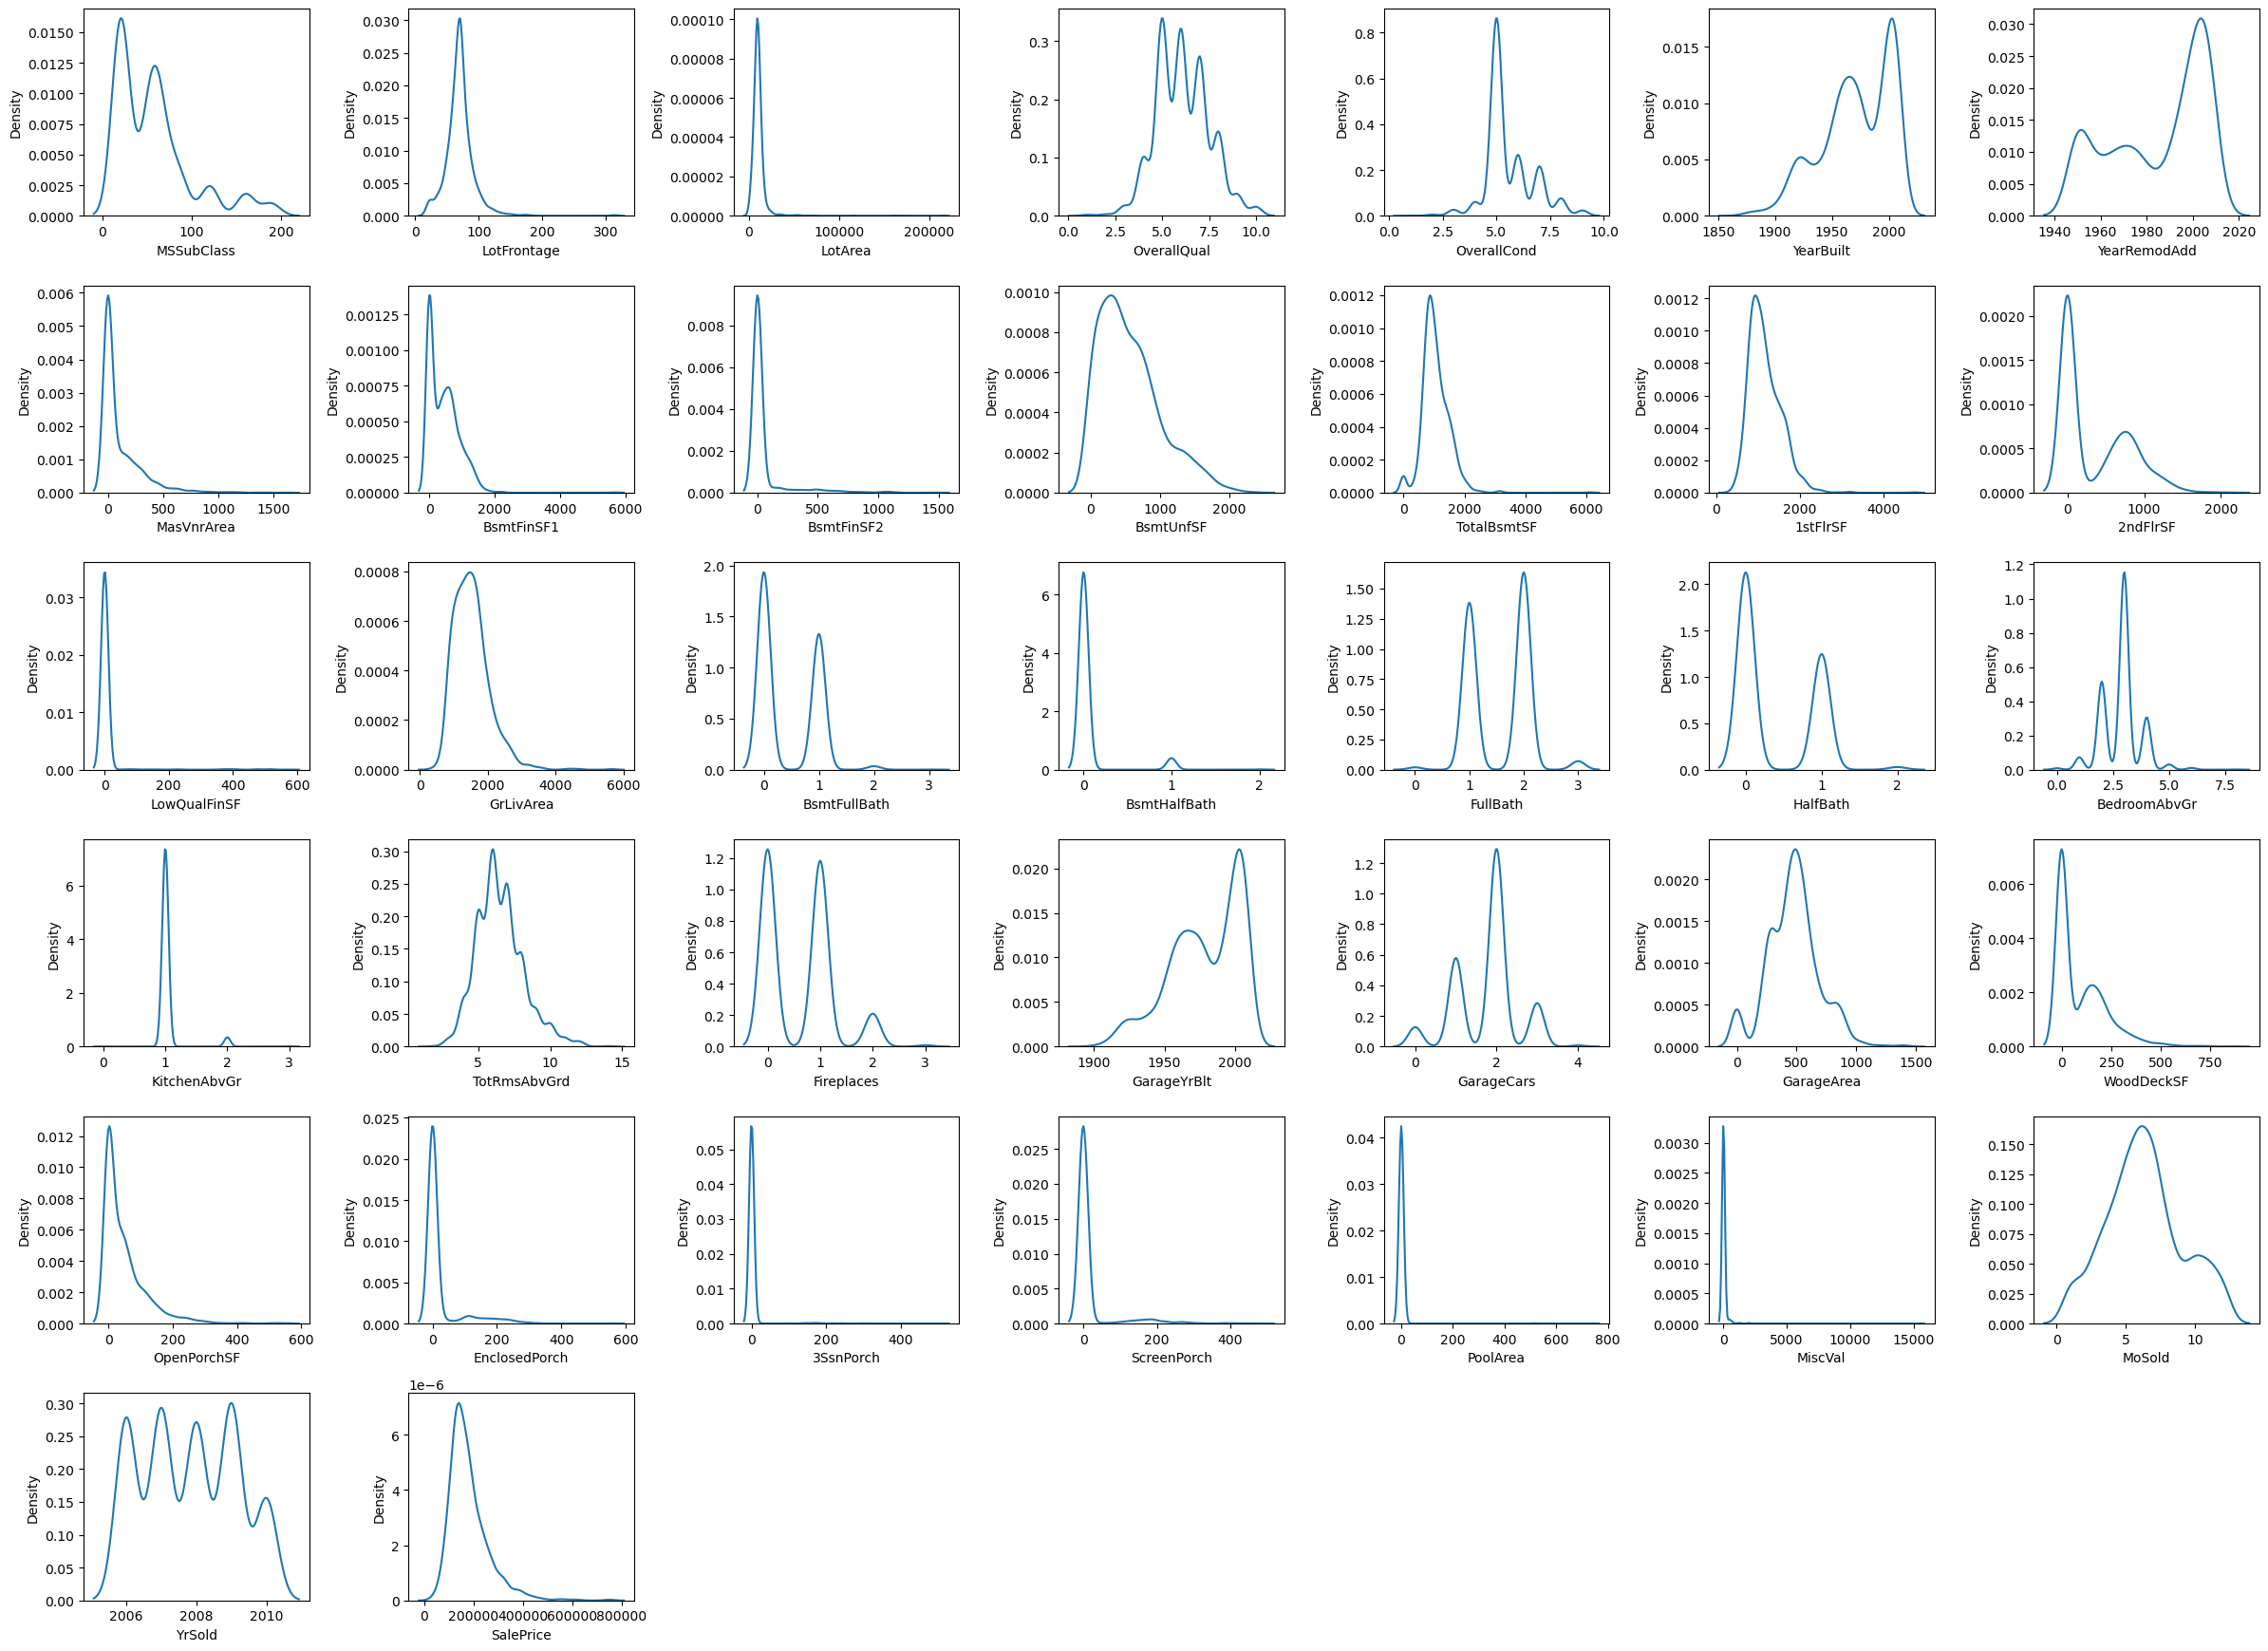

In [176]:
plt.figure(figsize=(24,20))
for i in range(1, len(train_nums.columns)):
    plt.subplot(7,7,i)
    sns.kdeplot(x=train[train_nums.columns[i]], label='Continuous Columns')
    plt.tight_layout()

In [178]:
features = train.columns

## Modelling :)

In [179]:
model_dict = {
    'Light GBM': LGBMRegressor(),
    'XG Boost' : XGBRegressor(),
    'Random Forest' :RandomForestRegressor(),
    'Linear': LinearRegression(),
    'Decision Tree' :DecisionTreeRegressor(),
    'Logistic Reg': LogisticRegression()
    
}

In [180]:
y = train['SalePrice']
train.drop(columns='SalePrice',inplace =True)

In [181]:
encoded_data = pd.get_dummies(train_cats.columns)
for cols in encoded_data.columns:
    train[cols] = encoded_data[cols]
    test[cols] = encoded_data[cols]

## Converting the categorical coumns to arrays

In [182]:
my_imputer = SimpleImputer()
data_with_imputed_values = my_imputer.fit_transform(train)
data_with_imputed_values_test = my_imputer.fit_transform(test)

In [183]:
X = data_with_imputed_values
X_validation = data_with_imputed_values_test


In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=52)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 80)
(292, 80)
(1168,)
(292,)


In [185]:
def evaluation(model_str, y_pred, y_pred_train):
    results = {
        'model': model_str,
        'rmseval': mean_squared_error(y_test, y_pred, squared=False),
        'rmse_train': mean_squared_error(y_train, y_pred_train, squared=False)
    }
    return results

## Model fitting the evaluation 

In [186]:
result_list = []
for model in model_dict:
    model_dict[model].fit(X_train, y_train)
    y_pred = model_dict[model].predict(X_test)
    y_pred_train = model_dict[model].predict(X_train)
    result = evaluation(model, y_pred, y_pred_train)
    result_list.append(result)
df_eval = pd.DataFrame(result_list)
df_eval

,model,rmseval,rmse_train
0,Light GBM,30839.112660,11825.140766
1,XG Boost,33077.479789,1469.230401
2,Random Forest,29941.120651,11559.571021
3,Linear,35606.987730,34212.663195
4,Decision Tree,43981.920684,0.000000
5,Logistic Reg,68200.240887,55278.069261


## Checking the best model from the above list

In [188]:
RF = RandomForestRegressor()
RF.fit(X_train,y_train)
RF.predict(X_test)
score = RF.score(X_test, y_test)
print(score)

0.8812624991056451


In [189]:
y_pred = RF.predict(X_validation)

## Creating the submission file 

In [190]:
output = pd.DataFrame({'Id': test['Id'], 'SalePrice': y_pred})
output.to_csv('submission.csv', index=False)